# Experiment 09: deeplabv3plus

Same as 07, but architecture is DeepLabV3+.

Average test dice: 0.5554

Public Leaderboard: 0.52

Testdice is now close to public leaderboard score. Also, best score for small encoders so far!

In [6]:
EXP_NAME = "09_deeplabv3plus"

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import monai
from typing import Union, Tuple, Any
from pathlib import Path
Path.ls = lambda p: list(p.iterdir())
from functools import partial
from fastai.data.transforms import get_image_files
import catalyst
from catalyst import dl
import segmentation_models_pytorch as smp
import albumentations as A

# Lookahead imports
from typing import Callable, Dict, Optional
from collections import defaultdict
import torch
from torch.optim import Optimizer

In [8]:
def get_device(verbose: bool = True) -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        if verbose: print("Using the GPU!")
    else:
        device = torch.device("cpu")
        if verbose: print("Using the CPU!")
    return device
    
def load_image_monai(fn: Union[Path, str]) -> np.array:
    image_array = monai.transforms.LoadImage(image_only=True)(str(fn))
    return image_array.__array__().astype(np.uint8)

def plot_image_mask(image: np.array, mask: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if not isinstance(mask, type(np.array([0]))): mask = mask.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    if len(mask.shape) == 3 and mask.shape[0] > 1: mask = mask[0]
    plt.figure(figsize=figsize)
    if image.mean() > 1: plt.imshow(image.astype(np.uint8), interpolation="none")
    else: plt.imshow(image.astype(np.float32), interpolation="none")
    plt.imshow(mask.astype(np.uint8), cmap="jet", alpha=0.5)
    
def plot_image(image: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="none")

def fn2image(fn: Union[Path, str]) -> np.array:
    return load_image_monai(fn)

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2fn(fid: str) -> Path:
    return COMBINED_DF[COMBINED_DF.id == int(fid)]["fnames"].values[0]

def id2rle(fid: str) -> str:
    rle = TRAIN_DF[TRAIN_DF.id==int(fid)]["rle"].values[0]
    return rle

def fn2rle(fn: Union[Path, str]) -> str:
    fid = fn2id(fn)
    return id2rle(fid)

def id2organ(fid: str) -> str:
    organ = TRAIN_DF[TRAIN_DF.id==int(fid)]["organ"].values[0]
    return organ

def id2shape(fid: str) -> Tuple[int, int]:
    width = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_width"].values[0]
    height = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_height"].values[0]
    return width, height

def fn2shape(fn: Union[Path, str]) -> Tuple[int, int]:
    fid = fn2id(fn)
    return id2shape(fid)

def load_mask(fn: Union[Path, str]) -> np.array:
    shape = fn2shape(fn)
    rle = fn2rle(fn)
    return rle_decode(rle, shape)

def fn2mask(fn: Union[Path, str]) -> np.array:
    return load_mask(fn)

def id2mask(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2mask(fn)

def save_df(df:Dict[str, Any], df_file:str, replace:bool=False):
    if replace: return pd.DataFrame(df).to_csv(df_file, index=False)
    try: 
        d = pd.read_csv(df_file)
        d = pd.concat([d, pd.DataFrame(df)])
    except FileNotFoundError: 
        d = pd.DataFrame(df)
    d.to_csv(df_file, index=False)

def load_df(df_file: str) -> pd.DataFrame:
    try:  df = pd.read_csv(df_file)
    except FileNotFoundError: df = None
    return df

In [9]:
def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

In [10]:
# From: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return np.reshape(img, shape)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [11]:
def split_df_train_test(df, colname, seed=9210, test_pct=0.2):
    df = df.copy()
    np.random.seed(seed)
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    test_ids = df.id.values[indices[:int(test_pct*len(indices))]]
    df[colname] = df.id.apply(lambda fid: fid in test_ids)
    return df

In [12]:
class Lookahead(Optimizer):
    """Implements Lookahead algorithm.

    It has been proposed in `Lookahead Optimizer: k steps forward,
    1 step back`_.

    Main origins of inspiration:
        https://github.com/alphadl/lookahead.pytorch (MIT License)

    .. _`Lookahead Optimizer\: k steps forward, 1 step back`:
        https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer: Optimizer, k: int = 5, alpha: float = 0.5):
        """@TODO: Docs. Contribution is welcome."""
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0


    def update(self, group):
        """@TODO: Docs. Contribution is welcome."""
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)


    def update_lookahead(self):
        """@TODO: Docs. Contribution is welcome."""
        for group in self.param_groups:
            self.update(group)


    def step(self, closure: Optional[Callable] = None):
        """Makes optimizer step.

        Args:
            closure (callable, optional): A closure that reevaluates
                the model and returns the loss.
        """
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss


    def state_dict(self):
        """@TODO: Docs. Contribution is welcome."""
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }


    def load_state_dict(self, state_dict):
        """@TODO: Docs. Contribution is welcome."""
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state


    def add_param_group(self, param_group):
        """@TODO: Docs. Contribution is welcome."""
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)


    @classmethod
    def get_from_params(
        cls, params: Dict, base_optimizer_params: Dict = None, **kwargs,
    ) -> "Lookahead":
        """@TODO: Docs. Contribution is welcome."""
        from catalyst.dl.registry import OPTIMIZERS

        base_optimizer = OPTIMIZERS.get_from_params(
            params=params, **base_optimizer_params
        )
        optimizer = cls(optimizer=base_optimizer, **kwargs)
        return optimizer

In [13]:
TRAIN_DF = pd.read_csv("../data/train.csv")
TEST_DF = pd.read_csv("../data/test.csv")

TRAIN_IMAGES = get_image_files("../data/train_images")
TEST_IMAGES = get_image_files("../data/test_images")
ALL_IMAGES = [*TRAIN_IMAGES, *TEST_IMAGES]

In [14]:
KEYS = ["image", "label"]
IMAGE = "image"
LABEL = "label"
DEVICE = get_device()
TRANSFORM_PROB = 0.5
CROP_SIZE = (2700, 2700)
IMAGE_SIZE = (256, 256)
MIN_CROP_SIZE = (160, 160) # Smallest imagesize in hidden testset (https://www.kaggle.com/competitions/hubmap-organ-segmentation/data)
EPOCHS = 200
ACCUM_STEPS = 1
BATCH_SIZE = 8
LR_BS = 4.6875e-05
LR = LR_BS * BATCH_SIZE * ACCUM_STEPS
EARLY_STOP_PATIENCE = 100

LOG_DIR = Path("../logs")/EXP_NAME
LOG_DIR.mkdir(exist_ok=True)

Using the GPU!


In [15]:
def add_fnames(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    fnames = []
    for fid in df.id.values: fnames.append([fname for fname in ALL_IMAGES if str(fid) in fname.stem][0])
    df["fnames"] = fnames
    return df

In [16]:
def test_model(
        model:torch.nn.Module, 
        dl:monai.data.DataLoader, 
        metric_func:callable, 
        threshold:float=0.5) -> float:
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in tqdm(iter(dl), total=len(dl)):
            X, y = data[IMAGE].to(DEVICE), data[LABEL]
            y_hat = model(X).detach().cpu()
            preds = [*preds, *[logit_process(i) for i in y_hat]]
            trues = [*trues, *[i for i in monai.data.decollate_batch(y)]]
    metric_func(preds, trues)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

def load_weights(model:torch.nn.Module, weights_path:Union[str,Path], device:torch.device=DEVICE)->torch.nn.Module:
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device)

In [17]:
def make3D(t: np.array) -> np.array:
    t = np.expand_dims(t, axis=2)
    t = np.concatenate((t,t,t), axis=2)
    return t

def plot_results(model, dl, threshold=0.5, figsize=10):
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    max_size = 2**16
    model = model.to(DEVICE)
    model.eval()
    ims, preds, labels = [], [], []
    with torch.no_grad():
        for item in tqdm(iter(dl), total=len(dl)):
            X, y = item[IMAGE].to(DEVICE), item[LABEL].cpu()
            y_hat = model(X).detach().cpu()
            ims = [*ims, *[im.numpy() for im in X.detach().cpu()]]
            preds = [*preds, *[logit_process(pred).numpy() for pred in y_hat]]
            labels = [*labels, *[lbl.numpy() for lbl in y]]
    
    vs = []
    for i, b in enumerate(range(len(preds))):
        if (i+1) * preds[0].shape[1] * figsize > max_size:
            print("Dataset to big, only displaying a portion of it!")
            break
        
        im = np.einsum("cwh->whc", ims[b])
        pred = make3D(preds[b][1])
        label = make3D(labels[b][1])
        vs.append(np.hstack((im, pred, label)))
    

    plt.figure(figsize=(figsize, figsize*len(vs)))
    plt.title("Input / Prediction / Target")
    plt.imshow(np.vstack(vs))

def one_batch(
        dl:monai.data.DataLoader, 
        b_idx:int=0, 
        unpacked:bool=False) -> Union[Dict[str, Any], Tuple[torch.Tensor, torch.Tensor]]:
    assert b_idx < len(dl), f"DataLoader only has {len(dl)} batches..."
    for i, items in enumerate(iter(dl)):
        if i == b_idx: 
            if unpacked:
                X, y = items[IMAGE].to(DEVICE), items[LABEL].to(DEVICE)
                return X, y
            return items
def batch2numpy(batch:Dict[str,torch.Tensor])->Tuple[np.array]:
    return batch[IMAGE].detach().cpu().numpy(), batch[LABEL].detach().cpu().numpy()
def plot_batch(batch:Dict[str, torch.Tensor], figsize:int=10):
    X, y = batch2numpy(batch)
    vstacks = []
    for b in range(X.shape[0]):
        im = X[b].transpose(1, 2, 0)
        msk = make3D(y[b, 1])
        vstacks.append(np.hstack((im,msk)))
    patchwork = np.vstack(vstacks)
    plt.figure(figsize=(figsize, figsize*X.shape[0]))
    plt.imshow(patchwork)

In [18]:
TRAIN_DF = add_fnames(TRAIN_DF)
TEST_DF = add_fnames(TEST_DF)
COMBINED_DF = pd.concat([TRAIN_DF, TEST_DF])
COMBINED_DF.drop(columns="rle").head(2)

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,fnames
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,../data/train_images/10274.tiff


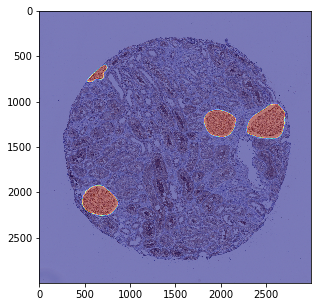

In [19]:
fn = np.random.choice(TRAIN_DF.fnames.values)
im = load_image_monai(fn)
mask = fn2mask(fn)
plot_image_mask(im, mask, figsize=(5, 5))

In [20]:
def alb_wrapper(arr, f):
    datatype = arr.dtype
    arr = torch.einsum("cwh->whc", arr) * 255.
    arr = f(image=arr.numpy().astype(np.uint8))["image"]
    arr = torch.Tensor(arr).to(datatype) / 255.
    return torch.einsum("whc->cwh", arr)
huesat = partial(alb_wrapper, f=A.HueSaturationValue(
    p=1, 
    hue_shift_limit=80,
    sat_shift_limit=80, 
    val_shift_limit=80, 
    always_apply=True))

In [21]:
def get_load_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
    ])

def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        *get_load_transforms().transforms,

        monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
        
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad((IMAGE,), huesat),
        
        monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandCoarseShuffled((IMAGE,), 
            holes=2, 
            max_holes=15, 
            spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
            max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
            prob=TRANSFORM_PROB),

        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_valid_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_test_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.EnsureTypeD(KEYS)
])

In [22]:
metrics_log = {"organ": [], "train_dice": [], "valid_dice": [], "test_dice": []}

for organ in TRAIN_DF.organ.unique():

    organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
    organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
    organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
    organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
    assert len(organ_testset_df.organ.unique()) == 1
    assert len(organ_train_valid_df.organ.unique()) == 1
    del organ_train_test_df

    train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
    valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
    test_ids = organ_testset_df.id.values
    assert len(set(train_ids).intersection(set(valid_ids))) == 0
    assert len(set(train_ids).intersection(set(test_ids))) == 0
    assert len(set(valid_ids).intersection(set(test_ids))) == 0

    data_dicts = {
        "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
        "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
        "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
    }

    train_ds = monai.data.CacheDataset(data_dicts["train"], transform=get_train_transforms())
    valid_ds = monai.data.CacheDataset(data_dicts["valid"], transform=get_valid_transforms())
    test_ds  = monai.data.CacheDataset(data_dicts["test"],  transform=get_valid_transforms())

    train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    loaders = {"train": train_dl, "valid": valid_dl}

    model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b3",        
        encoder_weights="imagenet",     
        in_channels=3,                  
        classes=2,  
    )

    criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

    dice_func = partial(
        calc_metric, 
        metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

    callbacks = [
        catalyst.dl.FunctionalMetricCallback(
        input_key="logits",
        target_key=LABEL,
        metric_fn=dice_func,
        metric_key="dice"
        ),
        catalyst.dl.OptimizerCallback(
            metric_key="loss", 
            accumulation_steps=ACCUM_STEPS),
        catalyst.dl.EarlyStoppingCallback(
            patience=EARLY_STOP_PATIENCE, 
            loader_key="valid", 
            metric_key="loss",
            min_delta=1e-3,
            minimize=True)
    ]

    runner = catalyst.dl.SupervisedRunner(
        input_key=IMAGE, 
        output_key="logits", 
        target_key=LABEL, 
        loss_key="loss"
    )

    runner.train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loaders=loaders,
        num_epochs=EPOCHS,
        callbacks=callbacks,
        logdir=LOG_DIR/organ,
        valid_loader="valid",
        valid_metric="loss",
        minimize_valid_metric=True,
        verbose=False,
        timeit=False,
        load_best_on_end=True
    )

    dice_metric = monai.metrics.DiceMetric(
        include_background=False, 
        reduction="mean")

    train_dice = test_model(model, train_dl, metric_func=dice_metric)
    valid_dice = test_model(model, valid_dl, metric_func=dice_metric)
    test_dice = test_model(model, test_dl, metric_func=dice_metric)

    metrics_log["organ"].append(organ)
    metrics_log["train_dice"].append(train_dice)
    metrics_log["valid_dice"].append(valid_dice)
    metrics_log["test_dice"].append(test_dice)
    save_df(metrics_log, LOG_DIR/"metrics.csv", replace=True)

print("Done.")

Loading dataset: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


train (1/200) dice: 0.31962665915489197 | dice/mean: 0.31962665915489197 | dice/std: 0.04726007645905833 | loss: 0.8598028736955978 | loss/mean: 0.8598028736955978 | loss/std: 0.06031321948885955 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.2530738562345505 | dice/mean: 0.2530738562345505 | dice/std: 0.011592083664260174 | loss: 0.8974345624446869 | loss/mean: 0.8974345624446869 | loss/std: 0.018891444822297914 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.27854254403535056 | dice/mean: 0.27854254403535056 | dice/std: 0.05595271095526799 | loss: 0.8967578411102295 | loss/mean: 0.8967578411102295 | loss/std: 0.06996382678235007 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.2425927072763443 | dice/mean: 0.2425927072763443 | dice/std: 0.004995438588839786 | loss: 0.9019931554794312 | loss/mean: 0.9019931554794312 | loss/std: 0.013057120730569687 | lr: 0.00033919068644530263 | momentum: 0.9
* Epo

Loading dataset: 100%|██████████| 5/5 [00:00<00:00,  5.07it/s]


train (1/200) dice: 0.2754454796130841 | dice/mean: 0.2754454796130841 | dice/std: 0.0803936227237246 | loss: 0.9176505437264075 | loss/mean: 0.9176505437264075 | loss/std: 0.07818164858875229 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.23338865033454365 | dice/mean: 0.23338865033454365 | dice/std: 0.06727395082513492 | loss: 0.9557819763819376 | loss/mean: 0.9557819763819376 | loss/std: 0.06651318073272705 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.28784041756238693 | dice/mean: 0.28784041756238693 | dice/std: 0.03806770716727799 | loss: 0.881033582565112 | loss/mean: 0.881033582565112 | loss/std: 0.05730290835187269 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.23503150128655964 | dice/mean: 0.23503150128655964 | dice/std: 0.07123423864444096 | loss: 0.9603042734993829 | loss/mean: 0.9603042734993829 | loss/std: 0.07067946592966716 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2

Loading dataset: 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


train (1/200) dice: 0.0823789495560858 | dice/mean: 0.0823789495560858 | dice/std: 0.026829239567706657 | loss: 1.0661020808749728 | loss/mean: 1.0661020808749728 | loss/std: 0.046577950088598254 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.04599224776029587 | dice/mean: 0.04599224776029587 | dice/std: 0.0 | loss: 1.1404621601104736 | loss/mean: 1.1404621601104736 | loss/std: 0.0 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.10697309879793061 | dice/mean: 0.10697309879793061 | dice/std: 0.05977232886159428 | loss: 1.0206451416015625 | loss/mean: 1.0206451416015625 | loss/std: 0.0716033876881835 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.05064775422215462 | dice/mean: 0.05064775422215462 | dice/std: 0.0 | loss: 1.1426790952682495 | loss/mean: 1.1426790952682495 | loss/std: 0.0 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch (2/200) lr: 0.00024544068644530265 | momentum: 0.9
train (3/20

Loading dataset: 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]


train (1/200) dice: 0.1260687311490377 | dice/mean: 0.1260687311490377 | dice/std: 0.043344507654277165 | loss: 1.0333775613043046 | loss/mean: 1.0333775613043046 | loss/std: 0.05147156713751414 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.06434798985719681 | dice/mean: 0.06434798985719681 | dice/std: 0.009442916799828121 | loss: 1.1300043132570055 | loss/mean: 1.1300043132570055 | loss/std: 0.010317240698841604 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.1122275988260905 | dice/mean: 0.1122275988260905 | dice/std: 0.0366894283659207 | loss: 1.0241018732388814 | loss/mean: 1.0241018732388814 | loss/std: 0.09186006406075423 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.06484043929311964 | dice/mean: 0.06484043929311964 | dice/std: 0.011104548492648645 | loss: 1.144644021987915 | loss/mean: 1.144644021987915 | loss/std: 0.013214804315166332 | lr: 0.00033919068644530263 | momentum: 0.9
* Epoch

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


train (1/200) dice: 0.4006731537885444 | dice/mean: 0.4006731537885444 | dice/std: 0.05333420798549214 | loss: 0.8280979478081991 | loss/mean: 0.8280979478081991 | loss/std: 0.04012099342127578 | lr: 0.000375 | momentum: 0.9
valid (1/200) dice: 0.33479703664779664 | dice/mean: 0.33479703664779664 | dice/std: 0.026335174134766926 | loss: 0.8440770030021667 | loss/mean: 0.8440770030021667 | loss/std: 0.026469803713560162 | lr: 0.000375 | momentum: 0.9
* Epoch (1/200) lr: 0.00033919068644530263 | momentum: 0.9
train (2/200) dice: 0.44947010417317235 | dice/mean: 0.44947010417317235 | dice/std: 0.06714745711521966 | loss: 0.7846624573995901 | loss/mean: 0.7846624573995901 | loss/std: 0.051866347065947525 | lr: 0.00033919068644530263 | momentum: 0.9
valid (2/200) dice: 0.3285059154033661 | dice/mean: 0.3285059154033661 | dice/std: 0.021483910229157455 | loss: 0.8552451610565186 | loss/mean: 0.8552451610565186 | loss/std: 0.02423530957324595 | lr: 0.00033919068644530263 | momentum: 0.9
* Epo

100%|██████████| 1/1 [00:00<00:00, 15.82it/s]

Done.


## End of submission model training

In [ ]:
test_dice

100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


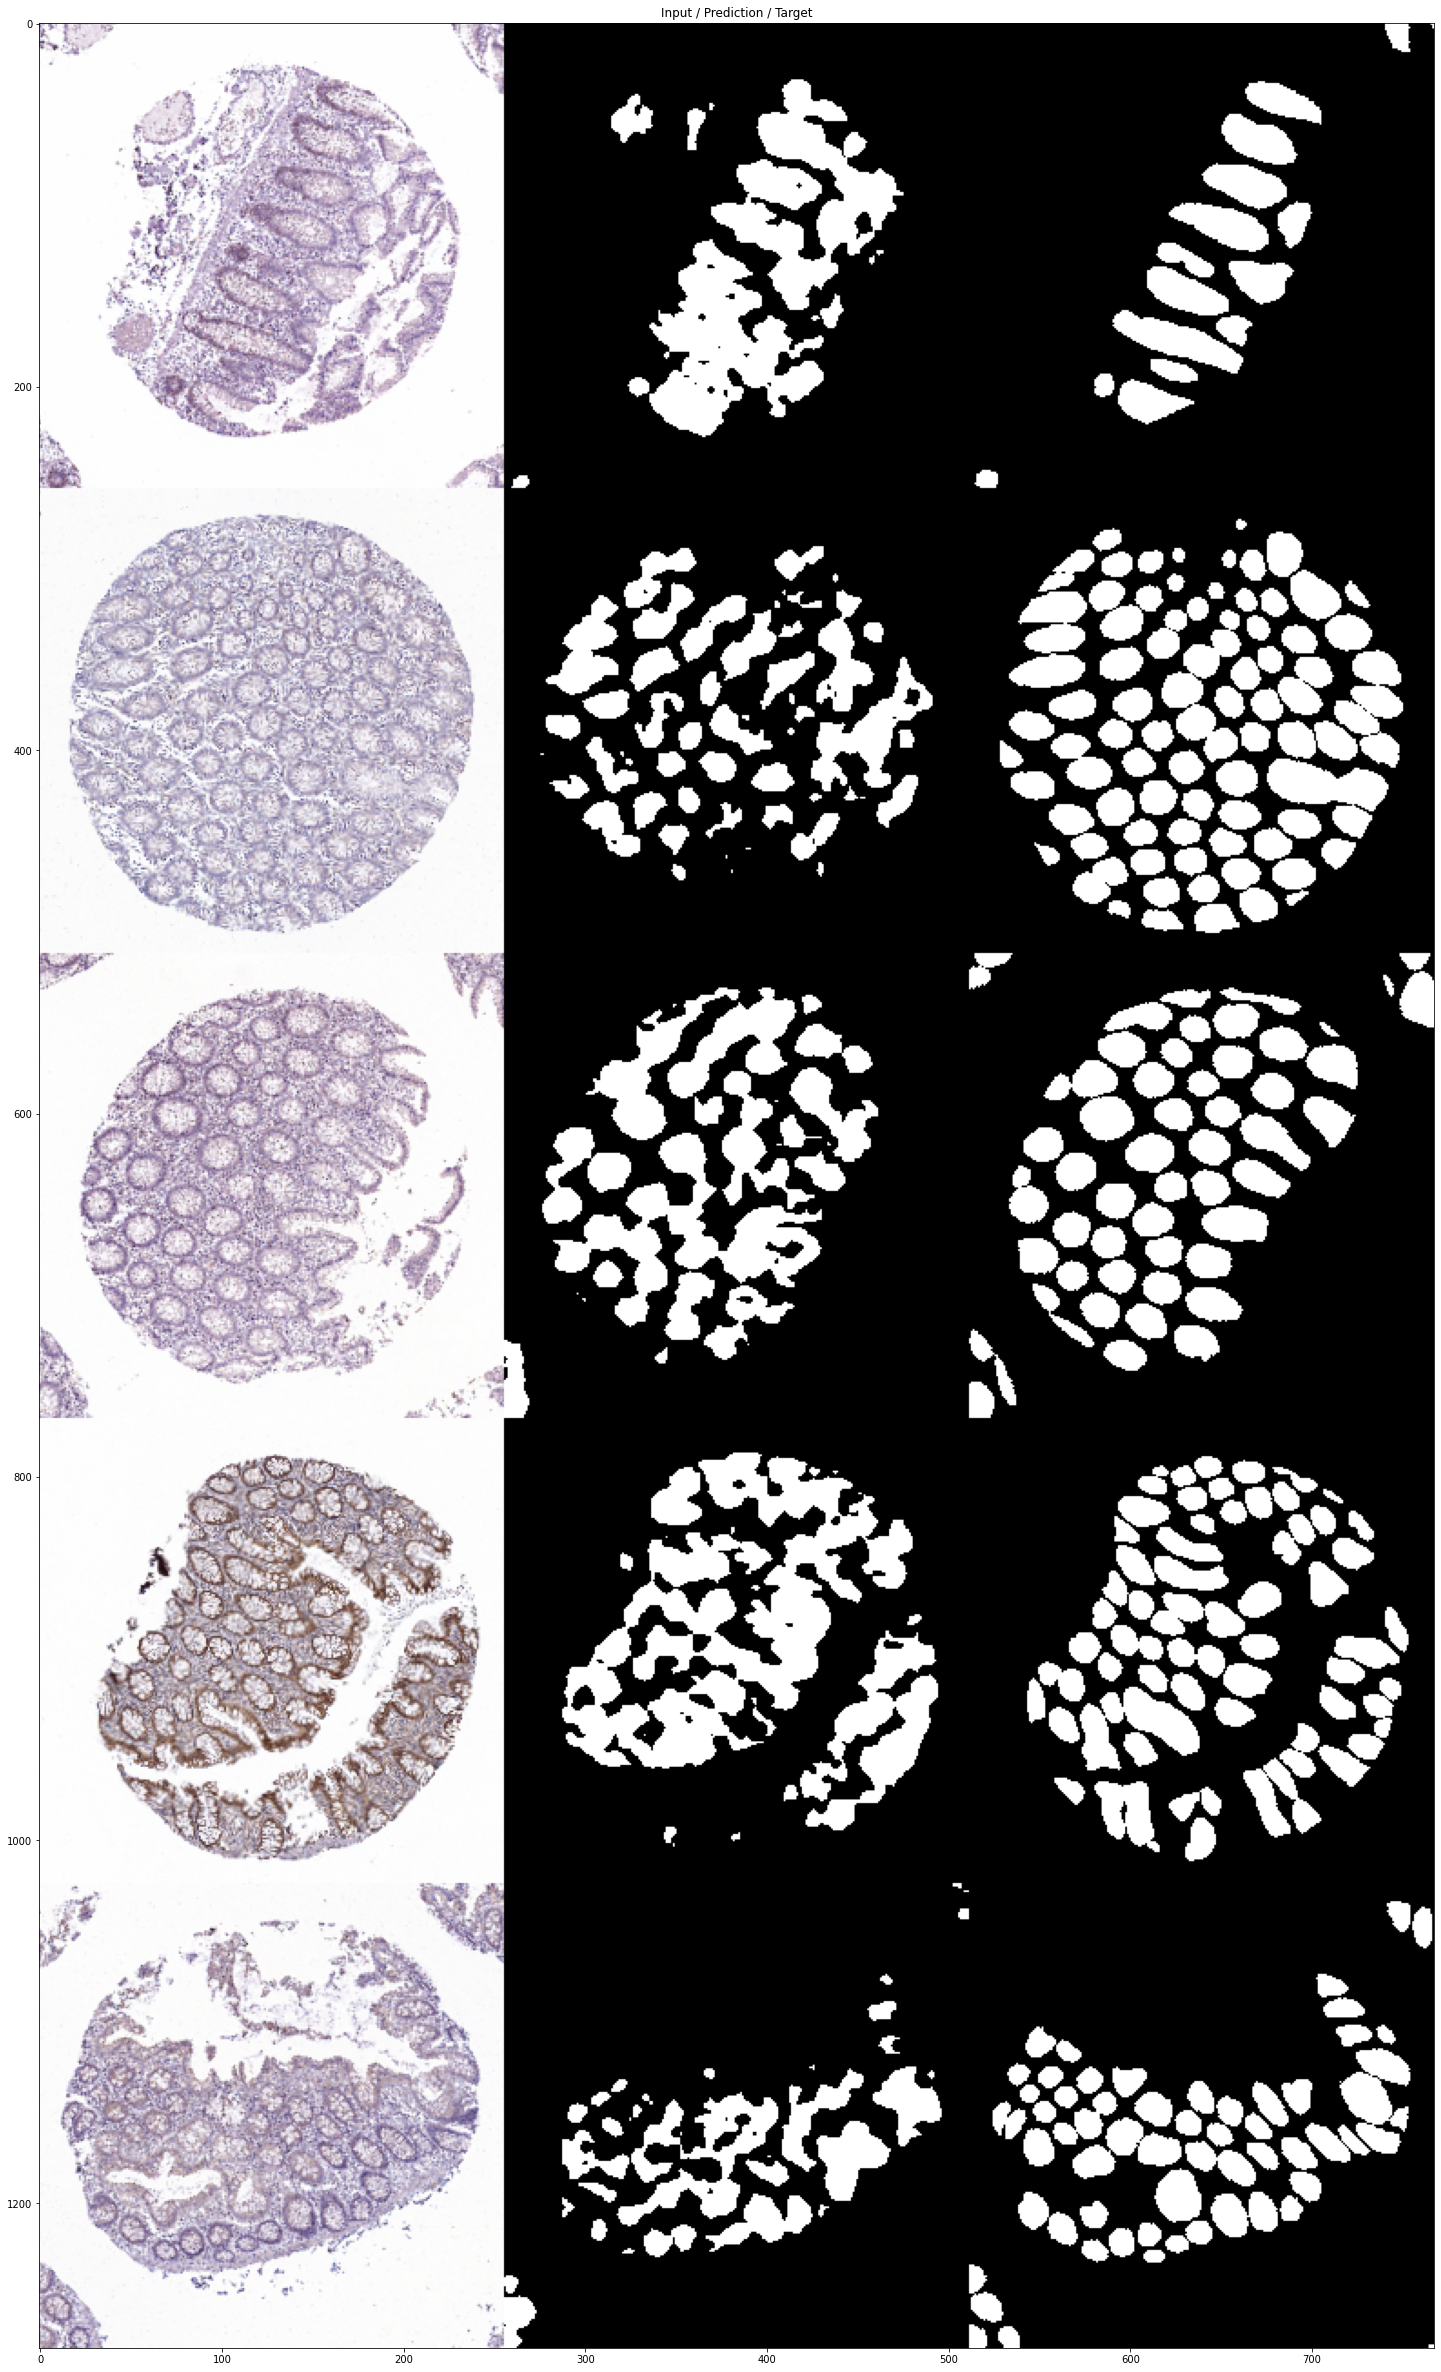

In [25]:
plot_results(model, test_dl, figsize=25, threshold=0.6)

In [26]:
d = one_batch(test_dl)

In [28]:
d[IMAGE].shape

(5, 3, 256, 256)

In [ ]:
organ = "spleen"

organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

train_ds = monai.data.Dataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.Dataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.Dataset(data_dicts["test"],  transform=get_test_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = load_weights(
    model, 
    f"/home/favi/work/kaggle/hubmap_reboot/logs/{EXP_NAME}/{organ}/checkpoints/model.0172.pth")
test_model(
    model, 
    test_dl, 
    metric_func=dice_metric)

In [ ]:
plot_results(model, test_dl)

In [ ]:
#monai.transforms.Lambdad((IMAGE,), id2image)

In [ ]:
def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
    *get_load_transforms().transforms,

    monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
    monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=TRANSFORM_PROB),
    monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
    monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
    monai.transforms.Lambdad((IMAGE,), huesat),
    
    monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
    monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
    monai.transforms.RandCoarseShuffled((IMAGE,), 
        holes=2, 
        max_holes=15, 
        spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
        max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
        prob=TRANSFORM_PROB),

    monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
    monai.transforms.EnsureTypeD(KEYS)
])

In [ ]:
organ = "prostate"

In [ ]:
organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

In [ ]:
train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

In [ ]:
train_ds = monai.data.Dataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.Dataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.Dataset(data_dicts["test"],  transform=get_valid_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

loaders = {"train": train_dl, "valid": valid_dl}

In [ ]:
plot_batch(one_batch(train_dl,b_idx=0))

In [ ]:
d = next(iter(train_dl))
msk = d[LABEL]

In [ ]:
criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

In [ ]:
def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

dice_func = partial(
    calc_metric, 
    metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

In [ ]:
callbacks = [
    catalyst.dl.FunctionalMetricCallback(
    input_key="logits",
    target_key=LABEL,
    metric_fn=dice_func,
    metric_key="dice"
    ),
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

In [ ]:
runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

In [ ]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=EPOCHS,
    callbacks=callbacks,
    logdir=LOG_DIR/organ,
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    timeit=False,
    load_best_on_end=True
)

In [ ]:
test_model(model, test_dl, monai.metrics.DiceMetric(
    include_background=False, 
    reduction="mean"),
    threshold=0.5)

In [ ]:
plot_results(model, test_dl, figsize=10)